# OpenAI Embeddings

本教程探讨了在 `LangChain` 框架中使用 `OpenAI 文本嵌入` 模型。

展示如何为文本查询和文档生成嵌入，使用 **PCA** 降维，并将其可视化为 2D 图形以便更好地理解。

通过分析查询与文档之间的 `余弦相似度`，该教程提供了嵌入如何增强工作流的洞察，包括 **文本分析** 和 **数据可视化**。

In [1]:
from langchain_openai import OpenAIEmbeddings

# Set desired model
openai_embedding = OpenAIEmbeddings(
	model="bge-m3",
	base_url='http://localhost:9997/v1',
	api_key='cannot be empty',
	# dimensions=1024,
)

query_vector = openai_embedding.embed_query("What is the Open AI's gpt embedding model?")

In [2]:
query = "How does AI improve healthcare?"

# Various embedding models
documents = [
    "AI helps doctors diagnose diseases faster, improving patient outcomes.",
    "AI can analyze medical images to detect conditions like cancer.",
    "Machine learning predicts patient outcomes based on health data.",
    "AI speeds up drug discovery by predicting the effectiveness of compounds.",
    "AI monitors patients remotely, enabling proactive care for chronic diseases.",
    "AI automates administrative tasks, saving time for healthcare workers.",
    "NLP extracts insights from electronic health records for better care.",
    "AI chatbots help with patient assessments and symptom checking.",
    "AI improves drug manufacturing, ensuring better quality and efficiency.",
    "AI optimizes hospital operations and reduces healthcare costs."
]

## embed 文本

In [3]:
query_vector = openai_embedding.embed_query(query)
docs_vector = openai_embedding.embed_documents(documents)

print("number of documents: " + str(len(docs_vector)))
print("dimension: " + str(len(docs_vector[0])))

# Part of the sliced ​​vector
print("query: " + str(query_vector[:5]))
print("documents[0]: " + str(docs_vector[0][:5]))
print("documents[1]: " + str(docs_vector[1][:5]))

number of documents: 10
dimension: 1024
query: [-0.008217299357056618, 0.05857884883880615, -0.015418872237205505, 0.02231411822140217, -0.028306419029831886]
documents[0]: [-0.04019297659397125, 0.020847423002123833, -0.019935578107833862, -0.03813512995839119, -0.04728339985013008]
documents[1]: [0.03994722664356232, 0.029537664726376534, -0.027887631207704544, -0.025838112458586693, -0.05827672779560089]


`embed_query` 和 `embed_documents` 没有根本的不同, 前者只是后者的特殊情况

```python
    def embed_query(self, text: str) -> List[float]:
        """Call out to OpenAI's embedding endpoint for embedding query text.

        Args:
            text: The text to embed.

        Returns:
            Embedding for the text.
        """
        return self.embed_documents([text])[0]
```

## 相似度计算（余弦相似度）

这段代码通过**余弦相似度**计算查询与文档之间的相似度。  
找出与查询最相似的**前 3 个文档**和**最不相似的 3 个文档**。

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate Cosine Similarity
similarity = cosine_similarity([query_vector], docs_vector)

# Sorting by in descending order
sorted_idx = similarity.argsort()[0][::-1]

# Display top 3 and bottom 3 documents based on similarity
print("query: ", query)
print("Top 3 most similar document:")
for i in range(0, 3):
    print(
        f"[{i+1}] similarity: {similarity[0][sorted_idx[i]]:.3f} | {documents[sorted_idx[i]]}"
    )

print("\nBottom 3 least similar documents:")
for i in range(1, 4):
    print(
        f"[{i}] similarity: {similarity[0][sorted_idx[-i]]:.3f} | {documents[sorted_idx[-i]]}"
    )

query:  How does AI improve healthcare?
Top 3 most similar document:
[1] similarity: 0.641 | AI monitors patients remotely, enabling proactive care for chronic diseases.
[2] similarity: 0.596 | AI chatbots help with patient assessments and symptom checking.
[3] similarity: 0.592 | AI automates administrative tasks, saving time for healthcare workers.

Bottom 3 least similar documents:
[1] similarity: 0.432 | Machine learning predicts patient outcomes based on health data.
[2] similarity: 0.485 | AI optimizes hospital operations and reduces healthcare costs.
[3] similarity: 0.503 | NLP extracts insights from electronic health records for better care.


**使用向量点积进行相似度计算**  
- 相似度通过向量的**点积**来确定。

- **相似度计算公式：**

$$ \text{similarities} = \mathbf{query} \cdot \mathbf{documents}^T $$

---

 📐 **向量点积的数学意义**

**向量点积的定义**

两个向量 $\mathbf{a}$ 和 $\mathbf{b}$ 的**点积**，在数学上定义为：

$$ \mathbf{a} \cdot \mathbf{b} = \sum_{i=1}^{n} a_i b_i $$

---

**与余弦相似度的关系**

**点积**与**余弦相似度**也有关系，遵循以下性质：

$$ \mathbf{a} \cdot \mathbf{b} = \|\mathbf{a}\| \|\mathbf{b}\| \cos \theta $$

其中：  
- $\|\mathbf{a}\|$ 和 $\|\mathbf{b}\|$ 表示向量 $\mathbf{a}$ 和 $\mathbf{b}$ 的**模长**（**范数，** 特指欧几里得范数）。  
- $\theta$ 是两向量之间的**夹角**。  
- $\cos \theta$ 表示两向量之间的**余弦相似度**。

---

**🔍 向量点积在相似度计算中的解释**

当**点积值很大**（即一个较大的正值）时：  
- 两个向量的**模长** ($\|\mathbf{a}\|$ 和 $\|\mathbf{b}\|$) 很大。  
- 两个向量之间的**夹角** ($\theta$) 很小（**$\cos \theta$ 接近 1**）。

这表示两个向量指向**相似的方向**，并且**语义上更为相似**，特别是当它们的模长也较大时。

---

📏 **向量的模长（范数）计算**

**欧几里得范数的定义**

对于一个向量 $\mathbf{a} = [a_1, a_2, \ldots, a_n]$，其**欧几里得范数** $\|\mathbf{a}\|$ 的计算方式为：

$$ \|\mathbf{a}\| = \sqrt{a_1^2 + a_2^2 + \cdots + a_n^2} $$

这个**模长**表示向量在多维空间中的**长度**或**大小**。

---

理解这些数学基础有助于确保精确的相似度计算，进而在**语义搜索**、**检索系统**和**推荐引擎**等任务中提高性能。 🚀

In [16]:
import numpy as np


def search_similar_documents(q, docs, hf_embeddings):
    """
    Search for the most relevant documents based on a query using text embeddings.

    Args:
        q (str): The query string for which relevant documents are to be found.
        docs (list of str): A list of document strings to compare against the query.
        hf_embeddings: An embedding model object with `embed_query` and `embed_documents` methods.

    Returns:
        tuple:
            - embedded_query (numpy.ndarray): The embedding vector of the query.
            - embedded_documents (numpy.ndarray): The embedding matrix of the documents.
    """
    # Embed the query and documents using the embedding model
    embedded_query = hf_embeddings.embed_query(q)
    embedded_documents = hf_embeddings.embed_documents(docs)

    # Calculate similarity scores using dot product and normalize with the magnitudes
    query_norm = np.linalg.norm(embedded_query)
    document_norms = np.linalg.norm(embedded_documents, axis=1)

    # Calculate cosine similarity: dot product / (query norm * document norm)
    similarity_scores = (embedded_query @ embedded_documents.T) / (query_norm * document_norms)

    # Sort documents by similarity scores in descending order
    sorted_idx = similarity_scores.argsort()[::-1]

    # Display the results
    print(f"[Query] {q}\n" + "=" * 40)
    for i, idx in enumerate(sorted_idx):
        print(f"[{i}] {docs[idx]}")
        print()

    # Return embeddings for potential further processing or analysis
    return embedded_query, embedded_documents


## 嵌入可视化（PCA）

为了可视化的目的，减少嵌入的维度。
这段代码使用 **主成分分析（PCA）** 将高维嵌入向量降至 **二维**。
生成的 **二维点** 在散点图中显示，每个点都标有对应文档的标签。

高维嵌入向量直接进行解读和分析非常具有挑战性。通过将它们降到二维，我们可以：

- **可视化探索嵌入之间的关系**（例如，聚类、分组）。
- **识别数据中的模式或异常**，这些模式在高维空间中可能不那么显眼。
- **提高可解释性**，使数据更加易于人类分析和决策。

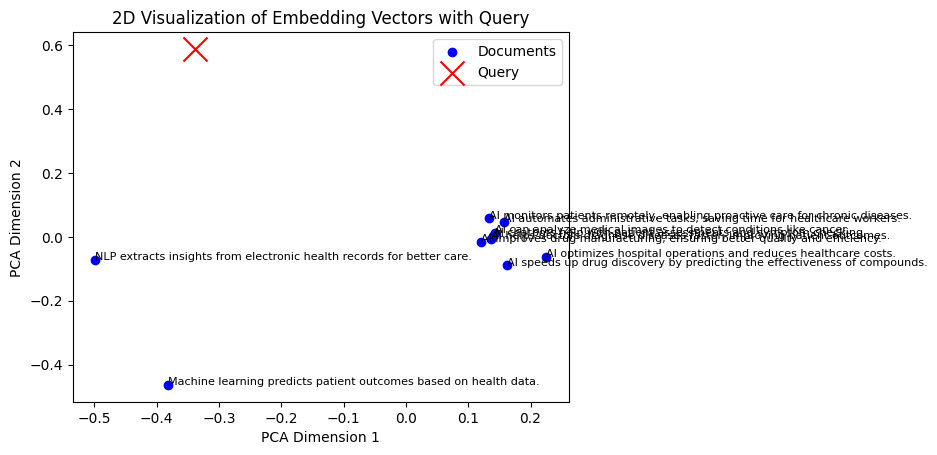

In [31]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Combine documents and query for PCA
all_vectors = np.vstack([docs_vector, query_vector])  # Stack query vector with docs
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(all_vectors)

# Separate reduced vectors for documents and query
doc_vectors_2d = reduced_vectors[:-1]  # All but the last point (documents)
query_vector_2d = reduced_vectors[-1]  # Last point (query)

# Plot the reduced vectors
plt.scatter(doc_vectors_2d[:, 0], doc_vectors_2d[:, 1], color="blue", label="Documents")
plt.scatter(query_vector_2d[0], query_vector_2d[1], color="red", label="Query", marker="x", s=300,)

# Annotate document points
for i, doc in enumerate(documents):
    plt.text(doc_vectors_2d[i, 0], doc_vectors_2d[i, 1], doc, fontsize=8)

# Add plot details
plt.title("2D Visualization of Embedding Vectors with Query")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend()
plt.show()

In [20]:
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

model_name = "../DataCollection/officials/bge-large-zh-v1.5"

hf_embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs={"device": 'cuda:1'},  # mps, cuda, cpu
    encode_kwargs={"normalize_embeddings": True},
)

In [27]:
vector = hf_embeddings.embed_query("Please tell me more about LangChain.")
print(len(vector))

vector = hf_embeddings.embed_documents([
    "Hi, nice to meet you.",
    "LangChain simplifies the process of building applications with large language models.",
    "The LangChain English tutorial is structured based on LangChain's official documentation, cookbook, and various practical examples to help users utilize LangChain more easily and effectively.",
    "LangChain simplifies the process of building applications with large-scale language models.",
    "Retrieval-Augmented Generation (RAG) is an effective technique for improving AI responses.",
])
print(len(vector))
print([len(item) for item in vector])

1024
5
[1024, 1024, 1024, 1024, 1024]


# CacheBackedEmbeddings

嵌入值可以存储或临时缓存，以避免重新计算。

缓存嵌入值可以使用 `CacheBackedEmbeddings` 来完成。缓存支持的嵌入器是对嵌入器的包装，它将嵌入存储在一个键值存储中。文本被哈希处理，哈希值作为缓存中的键。

In [1]:
import os

os.makedirs("./cache/", exist_ok=True)
print(os.path.exists("./cache/"))  # Check if the directory exists
print(os.access("./cache/", os.W_OK))  # Check if the directory is writable

True
True


## 使用嵌入与本地文件存储（持久化存储）

初始化 `CacheBackedEmbeddings` 的主要支持方法是 `from_bytes_store`。

它接受以下参数：

- `underlying_embeddings`: 用于生成嵌入的嵌入器。
- `document_embedding_cache`: 用于缓存文档嵌入的 `ByteStore` 实现之一。
- `namespace`: （可选，默认值为 `""`）命名空间用于文档缓存。这样可以避免与其他缓存发生冲突。例如，可以将其设置为正在使用的嵌入模型的名称。

**注意**：设置 `namespace` 参数非常重要，以避免在使用不同的嵌入模型对相同文本进行嵌入时发生冲突。

首先，让我们看一个使用本地文件系统存储嵌入，并使用 FAISS 向量存储进行检索的例子。

In [2]:
from langchain.storage import LocalFileStore
from langchain_openai import OpenAIEmbeddings
from langchain.embeddings import CacheBackedEmbeddings
from langchain_community.vectorstores.faiss import FAISS

# Configure basic embeddings using OpenAI embeddings
underlying_embeddings = OpenAIEmbeddings(
	model="bge-m3",
	base_url='http://localhost:9997/v1',
	api_key='cannot be empty',
	# dimensions=1024,
)

# Set up a local file storage
store = LocalFileStore("./cache/")

# Create embeddings with caching support
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    underlying_embeddings=underlying_embeddings, 
    document_embedding_cache=store, 
    namespace=underlying_embeddings.model, # Create a cache-backed embedder using the base embedding and storage
)

在 embedding 之前 cache 是空的

In [3]:
list(store.yield_keys())

[]

加载文档，将其拆分为多个块，对每个块进行嵌入，并将嵌入加载到向量存储中。

In [4]:
from langchain.document_loaders import TextLoader
from langchain_text_splitters import CharacterTextSplitter

raw_documents = TextLoader("./data/appendix-keywords.txt", encoding="utf-8").load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
documents = text_splitter.split_documents(raw_documents)

从文档创建 FAISS 数据库。

In [5]:
%time db = FAISS.from_documents(documents, cached_embedder)

CPU times: user 375 ms, sys: 43 ms, total: 418 ms
Wall time: 809 ms


如果我们尝试再次创建向量存储，它会更快，因为无需重新计算任何嵌入。

In [6]:
%time db2 = FAISS.from_documents(documents, cached_embedder)

CPU times: user 13.7 ms, sys: 1.04 ms, total: 14.7 ms
Wall time: 13.8 ms


In [7]:
list(store.yield_keys())[:5]

['bge-m34b802135-9b69-54ac-835f-f31f0a8f73cf',
 'bge-m34fd4987e-f5b6-52f8-91e2-886802754643',
 'bge-m3229c1600-8452-5938-b611-45db25315327',
 'bge-m3fed9c955-3b6d-5ce9-b7d2-235f35d18610',
 'bge-m39668cb63-4ad2-528c-9bf2-aecbfa54e1cd']

## 使用 `InMemoryByteStore`（非持久化）

要使用不同的 `ByteStore`，只需在创建 `CacheBackedEmbeddings` 时指定所需的 `ByteStore`。

以下是使用非持久化的 `InMemoryByteStore` 创建相同缓存嵌入对象的示例。

In [8]:
from langchain.embeddings import CacheBackedEmbeddings
from langchain.storage import InMemoryByteStore

# Create an in-memory byte store
store = InMemoryByteStore()

underlying_embeddings = OpenAIEmbeddings(
	model="bge-m3",
	base_url='http://localhost:9997/v1',
	api_key='cannot be empty',
	# dimensions=1024,
)

cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    underlying_embeddings, store, namespace=underlying_embeddings.model
)

In [15]:
%time db = FAISS.from_documents(documents, cached_embedder)  
list(store.yield_keys())[:5]

CPU times: user 6.92 ms, sys: 905 μs, total: 7.82 ms
Wall time: 7.34 ms


['bge-m34b802135-9b69-54ac-835f-f31f0a8f73cf',
 'bge-m34fd4987e-f5b6-52f8-91e2-886802754643',
 'bge-m3229c1600-8452-5938-b611-45db25315327',
 'bge-m3fed9c955-3b6d-5ce9-b7d2-235f35d18610',
 'bge-m39668cb63-4ad2-528c-9bf2-aecbfa54e1cd']